# Cluster count-only SACC file creation

This notebook examplifies the creation of a SACC file for cluster count, using pre-extracted halo catalog from the SkySim dataset. It
- shows how to load the data
- counts halos in the richness and redshift plane
- computes the covariance using jackknife resampling (to be eventually done by TJPCov)
- **save the count and covariance in the SACC format**

In [1]:
%load_ext autoreload
%autoreload 2
#!/usr/bin/env python

try:
    import gi

    gi.require_version("NumCosmo", "1.0")
    gi.require_version("NumCosmoMath", "1.0")
except:
    pass

import math
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
import sys

sys.path.insert(0, "../../scripts")
import os
import numpy as np
from astropy.table import Table
from numpy import random
import scipy
import matplotlib.pyplot as plt
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData
from clmm import Cosmology
from clmm.support import mock_data as mock
import pandas as pd
import numpy as np
import pyccl as ccl
import sacc

clmm.__version__
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import scipy.integrate
import astropy.units as u


Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

%matplotlib inline
catalog = "skysim5000_v1.1.1"
sys.path.insert(0, "/pbs/home/e/ebarroso/gcr-catalogs")
import GCRCatalogs

GCRCatalogs.set_root_dir_by_site("in2p3")
skysim_cat = GCRCatalogs.load_catalog(catalog)
cosmo_ss = skysim_cat.cosmology

In [2]:
sacc.__version__

'0.6'

In [3]:
cosmo = Nc.HICosmoDEXcdm()
reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)

# psml = Nc.PowspecMLCBE.new ()
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()


cosmo.props.H0 = cosmo_ss.H0.value
cosmo.props.Omegab = cosmo_ss.Ob0
cosmo.props.Omegac = cosmo_ss.Odm0
cosmo.props.Omegax = cosmo_ss.Ode0

cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.0)

prim.props.n_SA = cosmo_ss.n_s
print(cosmo_ss.sigma8, cosmo.sigma8(psf), cosmo.Omega_k0())

old_amplitude = math.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log(
    (cosmo_ss.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(cosmo_ss.sigma8, cosmo.sigma8(psf))
print(
    cosmo_ss.H0.value,
    cosmo_ss.Ob0,
    cosmo_ss.Odm0,
    cosmo_ss.Ode,
    cosmo_ss.n_s,
    cosmo_ss.Neff,
)

0.8 0.8490796381176396 0.0
0.8 0.7999999999999999
71.0 0.0448 0.21999999999999997 <bound method FLRW.Ode of FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.2648, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.0448)> 0.963 3.04


In [4]:
# CosmoSim_proxy model
# M_0, z_0
theta_pivot = [3e14 / 0.71, 0.6]


area = 439.78986
lnRl = 0.0
lnRu = 5.0
zl = 0.2
zu = 0.65

# Numcosmo_proxy model based on arxiv 1904.07524v2
cluster_z = Nc.ClusterRedshift.new_from_name(
    "NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (zl, zu)
)

cluster_m = Nc.ClusterMass.new_from_name(
    "NcClusterMassAscaso{'M0':<%20.15e>,'z0':<%20.15e>,'lnRichness-min':<%20.15e>, 'lnRichness-max':<%20.15e>}"
    % (3e14 / (0.71), 0.6, lnRl, lnRu)
)
cluster_m.param_set_by_name("mup0", 3.19)
cluster_m.param_set_by_name("mup1", 2 / np.log(10))
cluster_m.param_set_by_name("mup2", -0.7 / np.log(10))
cluster_m.param_set_by_name("sigmap0", 0.33)
cluster_m.param_set_by_name("sigmap1", -0.08 / np.log(10))
cluster_m.param_set_by_name("sigmap2", 0 / np.log(10))

In [5]:
# Numcosmo Mass Function

# First we need to define the multiplicity function here we will use the tinker
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)
mulf.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
mulf.set_Delta(200)
# Second we need to construct a filtered power spectrum

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area_sd(area)

# Cluster Abundance Obj
ca = Nc.ClusterAbundance.new(hmf, None)

In [6]:
# Number Counts object
ncount = Nc.DataClusterNCount.new(ca, "NcClusterRedshiftNodist", "NcClusterMassAscaso")
ca.prepare(cosmo, cluster_z, cluster_m)
mset = Ncm.MSet.new_array([cosmo, cluster_z, cluster_m])

rng = Ncm.RNG.seeded_new(None, 42)

#ncount.init_from_sampling(mset, area * ((np.pi / 180) ** 2), rng)
#print(ncount.desc)

In [7]:
# ncount.catalog_save ("ncount_rich.fits", True)
ncount.catalog_load("/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/NumCosmo_data/ncount_rich_32.fits")

ncdata_fits = fits.open("/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/NumCosmo_data/ncount_rich_32.fits")
# ncdata_fits.info()

ncdata_data = ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
# ncdata_Table.sort('LNM_TRUE')

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.4285610549833374,0.5957536546898285,0.4285610549833374,30.2555078520757
0.46818292662884137,1.9609581533708877,0.46818292662884137,31.393096588512037
0.5604603014832846,0.45802389064568433,0.5604603014832846,31.049929670576994
0.5803645711453446,2.6992573377148728,0.5803645711453446,33.169450212989204
0.29041200512733045,2.2674881094190025,0.29041200512733045,32.585655923608414
0.47562160407454523,0.4508157180975424,0.47562160407454523,30.3289848721656
0.5622845981630332,0.26606575908401875,0.5622845981630332,30.04128067052109
0.33913435874627446,0.14554227067695083,0.33913435874627446,30.15837397197179
0.2504733976167686,1.140613719054631,0.2504733976167686,30.910784343381827


## Plot of Cluster Mass versus Richness

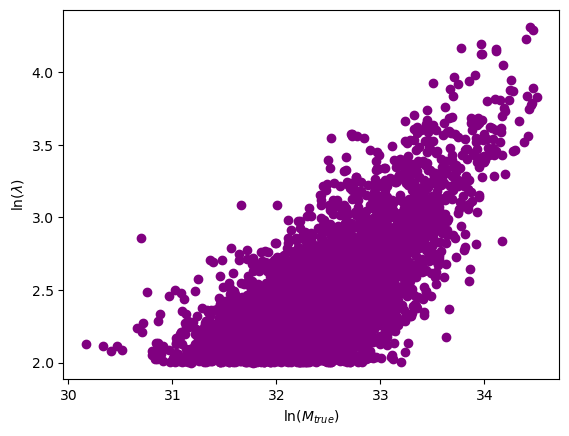

In [8]:
plt.scatter((ncdata_Table["LNM_TRUE"][ncdata_Table["LNM_OBS"] > 2]), (ncdata_Table["LNM_OBS"][ncdata_Table["LNM_OBS"] > 2]), color="purple")
plt.xlabel("$\ln(M_{true})$")
plt.ylabel("$\ln(\lambda)$")
plt.savefig("richscatter", bbox_inches="tight")

## Saving in SACC format

In [9]:
data_table = ncdata_Table[ncdata_Table["LNM_OBS"] > 2]
cluster_z = data_table["Z_OBS"]
cluster_lnm = data_table["LNM_OBS"]
cluster_z = np.array(cluster_z)
cluster_richness = np.log10(np.exp(np.array(cluster_lnm)))

## Count halos in the $N_{\rm richness} \times N_z$ richness-redshift plane

[0.86860026 1.06961066 1.27062106 1.47163146 1.67264186 1.87365226]
1883657153163898.8
[[389. 183.  78.  26.   4.]
 [591. 259. 101.  25.   4.]
 [795. 309.  96.  36.   7.]
 [856. 304. 102.  27.   5.]]


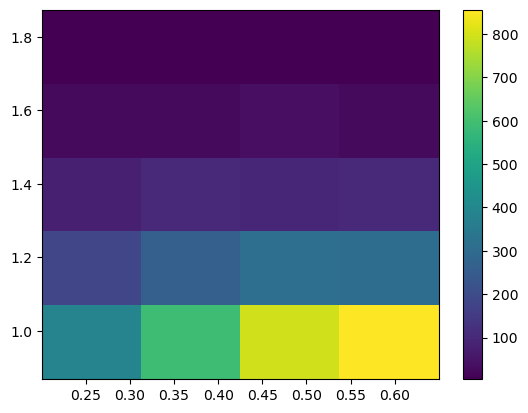

In [10]:
N_richness = 5  # number of richness bins
N_z = 4  # number of redshift bins

data_lz, z_edges, richness_edges, im = plt.hist2d(
    cluster_z, (cluster_richness), bins=[N_z, N_richness]
)
print(richness_edges)
print(1883657153163898.8)
fig = plt.colorbar()
plt.savefig("bins")
np.log(10)
print(data_lz)

## Mean Mass inside bins

In [11]:
ncdata_fits = fits.open("/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/NumCosmo_data/ncount_rich_32.fits")
# ncdata_fits.info()
mean_mass = []
ncdata_data = ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
cov_data = []
for i in range(0, len(z_edges)-1):
    for j in range(0, len(richness_edges)-1):
        z_bin = [z_edges[i], z_edges[i+1]]
        r_bin = [richness_edges[j], richness_edges[j+1]]
        redshift_cut = ncdata_Table[ncdata_Table["Z_OBS"] > z_bin[0]]
        redshift_cut = redshift_cut[redshift_cut["Z_OBS"] < z_bin[1]]
        rich_cut = redshift_cut[np.log10(np.exp(redshift_cut["LNM_OBS"])) > r_bin[0]]
        final_cut = rich_cut[np.log10(np.exp(rich_cut["LNM_OBS"])) < r_bin[1]]
        mean_mass.append(np.mean(np.log10(np.exp(final_cut["LNM_TRUE"]))))
        cov_data.append(np.var(np.log10(np.exp(final_cut["LNM_TRUE"]))))
cov_data = cov_data / data_lz.flatten()
print(cov_data)

[1.02546128e-04 2.43138645e-04 3.02888296e-04 2.03679160e-03
 3.54681788e-03 7.63788572e-05 1.75081796e-04 3.98935350e-04
 1.23638618e-03 1.96293710e-03 5.56209264e-05 1.31863461e-04
 2.78668225e-04 1.13046096e-03 2.48832075e-03 4.89794717e-05
 1.26824541e-04 2.44937155e-04 1.05896466e-03 1.98667048e-03]


## Covariance


[13.9762805836693, 14.180122821373832, 14.434494332493264, 14.591319243539187, 14.77056672637548, 13.95215398359329, 14.199676296351242, 14.401159673316974, 14.674268226046253, 14.848236706795934, 13.975742932428782, 14.200635914109064, 14.40551857613074, 14.640961339619038, 14.751735978700866, 13.978486066386527, 14.181663431450351, 14.413574534067807, 14.609635387388316, 14.763651339948634]
[1.02546128e-04 2.43138645e-04 3.02888296e-04 2.03679160e-03
 3.54681788e-03 7.63788572e-05 1.75081796e-04 3.98935350e-04
 1.23638618e-03 1.96293710e-03 5.56209264e-05 1.31863461e-04
 2.78668225e-04 1.13046096e-03 2.48832075e-03 4.89794717e-05
 1.26824541e-04 2.44937155e-04 1.05896466e-03 1.98667048e-03]


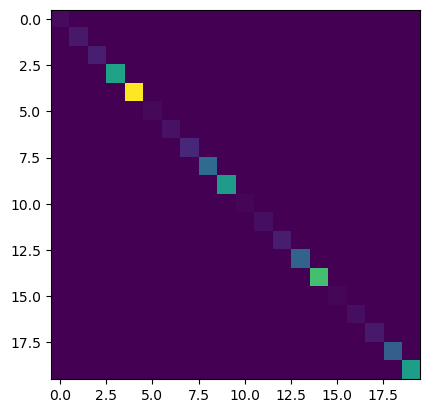

In [12]:
data = np.array(mean_mass)
print(mean_mass)
print(cov_data)
covariance = np.zeros((N_richness * N_z, N_richness * N_z))
np.fill_diagonal(covariance, cov_data)
plt.imshow((covariance))

**Correlation matrix - the "large blocks" correspond to the $N_z$ redshift bins. In each redshift bin are the $N_{\rm richness}$ richness bins.**

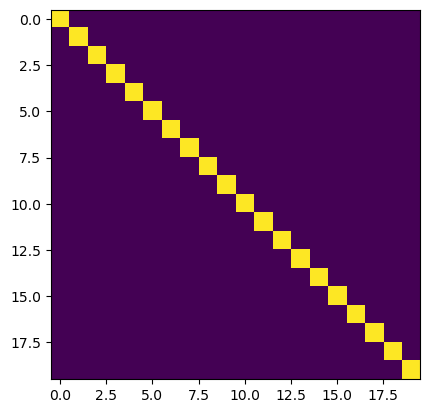

In [13]:
plt.imshow(np.corrcoef(covariance))
# plt.imshow((covariance))

## Store everything in a SACC file

In [14]:
s_count = sacc.Sacc()

In [15]:
# First we build the cluster count tracer
# Here we will store the richness and redshift bin information in metadata,
name = f"cluster_counts_richness_meanonly_proxy"
metadata = {
    "Mproxy_type": "richness_proxy",
    "Mproxy_edges": richness_edges,
    "z_type": "true_redshift",
    "z_edges": z_edges,
    "sky_area": area,
}
s_count.add_tracer("misc", name, metadata=metadata)

### First the count values

In [16]:
# One of our identifiers is a standard type name that is predefined
cluster_count = sacc.standard_types.cluster_mass_count_wl

for value in data:
        tracer = name
        s_count.add_data_point(cluster_count, (tracer,), (value), err=1.0)

In [17]:
for d in s_count.data:
    print(d)

DataPoint(data_type='cluster_mass_count_wl', tracers=('cluster_counts_richness_meanonly_proxy',), value=13.9762805836693, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('cluster_counts_richness_meanonly_proxy',), value=14.180122821373832, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('cluster_counts_richness_meanonly_proxy',), value=14.434494332493264, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('cluster_counts_richness_meanonly_proxy',), value=14.591319243539187, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('cluster_counts_richness_meanonly_proxy',), value=14.77056672637548, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('cluster_counts_richness_meanonly_proxy',), value=13.95215398359329, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('cluster_counts_richness_meanonly_proxy',), value=14.199676296351242, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('cluster_counts_ric

In [18]:
print(s_count.tracers[name].metadata)

{'Mproxy_type': 'richness_proxy', 'Mproxy_edges': array([0.86860026, 1.06961066, 1.27062106, 1.47163146, 1.67264186,
       1.87365226]), 'z_type': 'true_redshift', 'z_edges': array([0.20009201, 0.31252844, 0.42496488, 0.53740131, 0.64983774]), 'sky_area': 439.78986}


### Then the add the covariance and save the file

In [19]:
s_count.add_covariance(covariance)

In [20]:
s_count.to_canonical_order()
s_count.save_fits("clusters_numcosmo_richness_meanonly_data.sacc", overwrite=True)

## Read in the SACC file and check content

In [21]:
s2 = sacc.Sacc.load_fits("./clusters_numcosmo_richness_meanonly_data.sacc")

In [22]:
tracer = s2.get_tracer("cluster_counts_richness_proxy")
print(tracer)
tp = ("cluster_mass_count_wl",)
cluster_count = sacc.standard_types.cluster_mass_count_wl
print(cluster_count)
test = s2.get_data_points(
    data_type=cluster_count, tracers=("cluster_counts_richness_proxy",)
)
dts = s2.get_data_types()
tracer_sets = s2.get_tracer_combinations(dts[0])
nz = s2.get_mean(
    data_type="cluster_mass_count_wl", tracers=("cluster_counts_richness_proxy",)
)
s2.indices(
    data_type="cluster_mass_count_wl", tracers=("cluster_counts_richness_proxy",)
)
print(nz)

KeyError: 'cluster_counts_richness_proxy'